In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

pd.set_option("display.max_colwidth",200)
pd.options.display.float_format = '{:,.3f}'.format

# Thành viên nhóm
| Họ và tên      | MSSV |
| ----------- | ----------- |
| Nguyễn Phú Thụ| 19120673|
| Lê Anh Vũ| 19120724|

# 1. Retail Store Sales Transactions (Scanner Data)

## 1.1 Mô tả dữ liệu:
- <span style="font-size:17px;font-family: Times New Roman;"> Dữ liệu chi tiết về doanh thu bán hàng thu được bằng cách quét mã vạch cho từng sản phẩm tại các điểm bán hàng (POS) của cửa hàng. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dữ liệu cung cấp thông tin chi tiết về số lượng, đặc điểm và giá trị của sản phầm bán ra.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Ý nghĩa các trường thuộc tính trong dataset:</span>
    | Syntax      | Description |
    | ----------- | ----------- |
    | Date | Ngày thực hiện giao dịch|
    | Customer ID   | ID khách hàng        |
    | Transaction ID      | ID giao dịch       |
    | SKU Category |  ID nhóm sản phẩm tại kho |
    | SKU       | ID sản phẩm tại kho  |
    | Quantity   | Số lượng sản phẩm |
    | Sales Amount | Số tiền bán hàng |
    
- <span style="font-size:18px;font-family: Times New Roman;">Link tham khảo: https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions </span>

## 1.2 Bài toán
- <span style="font-size:17px;font-family: Times New Roman;">Sử dụng dữ liệu để xác định các mẫu mua hàng của khách hàng, khai thác quy tắc kết hợp bằng thuật toán Apriori.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Từ đó giúp các điểm bán lẻ (POS) tối ưu chi phí luân chuyển hàng hóa, kho chứa hàng tồn,... và nâng cao doanh số bán hàng.</span>

# 2. Khám phá dữ liệu

In [2]:
retail_sale_df = pd.read_csv('scanner_data.csv')
retail_sale_df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,02/01/2016,2547,1,X52,0EM7L,1.000,3.130
1,02/01/2016,822,2,2ML,68BRQ,1.000,5.460
2,02/01/2016,3686,3,0H2,CZUZX,1.000,6.350
3,02/01/2016,3719,4,0H2,549KK,1.000,5.590
4,02/01/2016,9200,5,0H2,K8EHH,1.000,6.880


## 2.1 Dữ liệu có bao nhiêu dòng vào cột

In [3]:
print(f'Dữ liệu có {retail_sale_df.shape[0]} dòng')
print(f'Dữ liệu có {retail_sale_df.shape[1]} cột')

Dữ liệu có 131706 dòng
Dữ liệu có 7 cột


## 2.2 Dữ liệu có bị trùng lặp không ?

In [4]:
retail_sale_df.duplicated().sum()

0

## 2.3 Kiểu dữ liệu có gì bất thường không ?

In [5]:
retail_sale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 7.0+ MB


<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Cột Date hiện đang có format `%d/%m/%Y`, nhóm sẽ tiến hành tiền xử lý về format `%Y-%m-%d` </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Các thuộc tính còn lại không có gì bất thường.</span>

### Tiền xử lý dữ liệu date

In [6]:
retail_sale_df['Date'] = pd.to_datetime(retail_sale_df['Date'].str.replace('/', '-'), format='%d-%m-%Y')

In [7]:
retail_sale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            131706 non-null  datetime64[ns]
 1   Customer_ID     131706 non-null  int64         
 2   Transaction_ID  131706 non-null  int64         
 3   SKU_Category    131706 non-null  object        
 4   SKU             131706 non-null  object        
 5   Quantity        131706 non-null  float64       
 6   Sales_Amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 7.0+ MB


## 2.4 Mỗi thuộc tính có dữ liệu thiếu hay không ?

In [8]:
retail_sale_df.isna().sum(axis = 0)

Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Dữ liệu không bị thiếu nên nhóm sẽ tập trung vào khám phá insight trước khi xây dựng mô hình học máy. </span>

## 2.5 Thống kê dữ liệu numeric
- <span style="font-size:17px;font-family: Times New Roman;"> Nhóm sẽ tính thêm cột Rate(đơn giá) vì Quantity có thể là số thực hoặc số nguyên nên standard uom(đơn vị tính) không đồng nhất. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dữ liệu numeric gồm 3 cột: Quantity, Rate và Sales_Amount.</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Mặc dù Customer_ID, Transaction_ID có kiểu dữ liệu `int64` nhưng ý nghĩ của chúng lại mang tính định danh nên vẫn sẽ thuộc vaò dữ liệu category.</span>

In [9]:
retail_sale_df['Rate'] = round(retail_sale_df['Sales_Amount'] / retail_sale_df['Quantity'], 2)

In [10]:
numeric_df = retail_sale_df[['Quantity', 'Rate', 'Sales_Amount']]
numeric_df.describe()

,Quantity,Rate,Sales_Amount
count,"131,706.000","131,706.000","131,706.000"
mean,1.485,9.692,11.982
std,3.873,14.945,19.360
min,0.010,0.020,0.020
25%,1.000,3.680,4.230
50%,1.000,6.070,6.920
75%,1.000,10.100,12.330
max,400.000,693.800,707.730


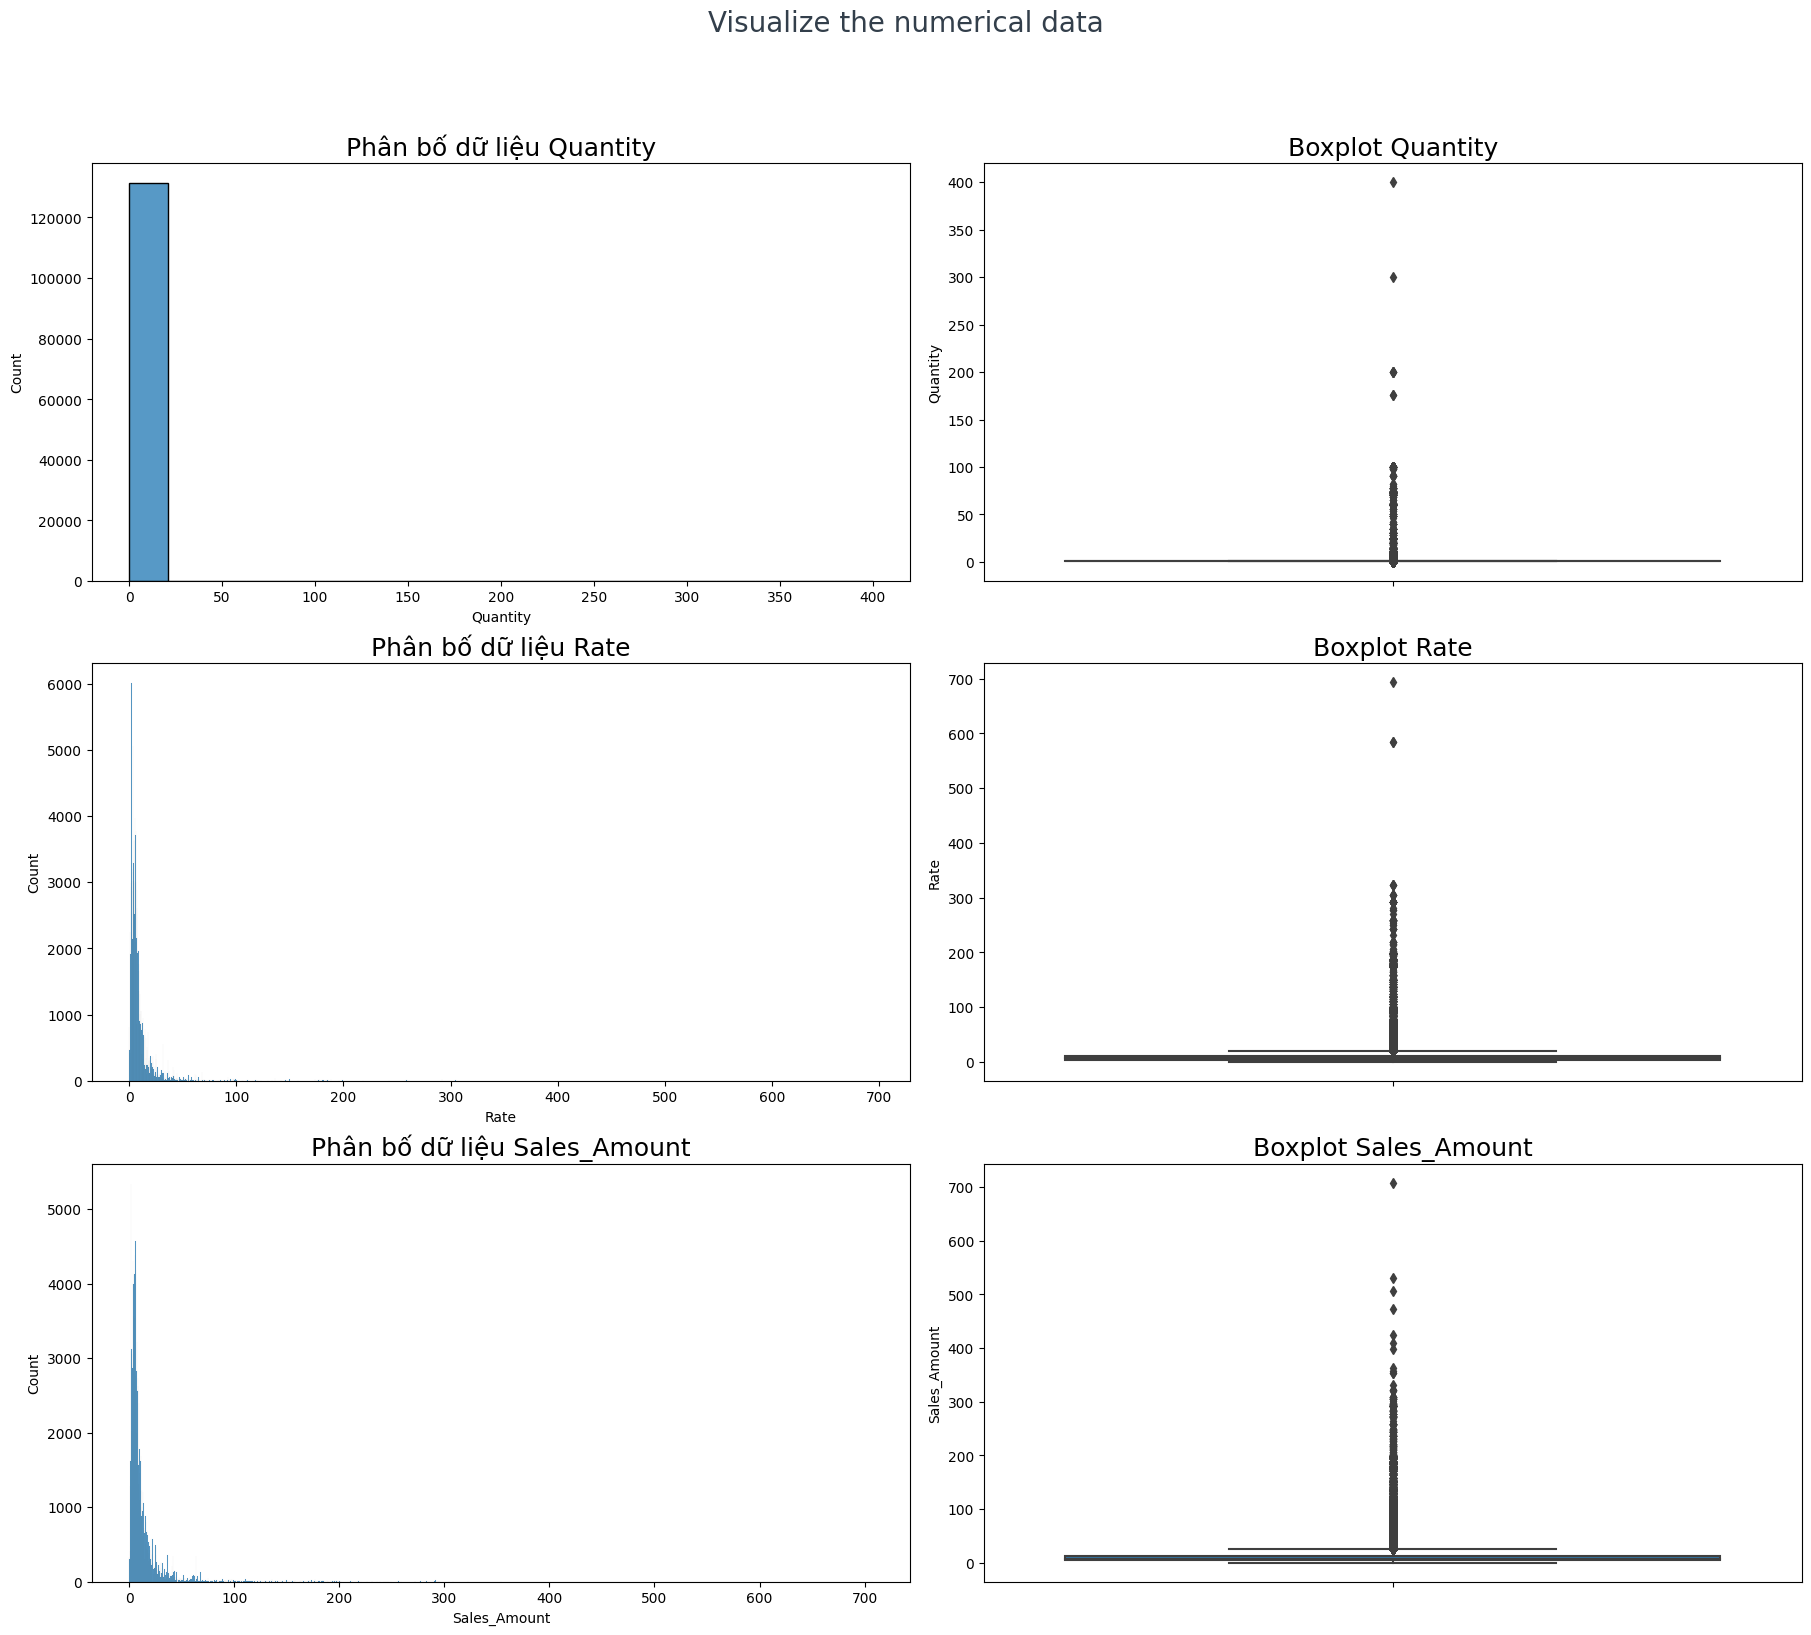

In [11]:
plt.rcParams['figure.figsize'] = 18, 15
fig , axs = plt.subplots(3,2,constrained_layout = True)
idx = 0
while idx < numeric_df.shape[1]:
    sns.histplot(x = numeric_df.iloc[:,idx], ax = axs[idx,0])
    axs[idx,0].set_title(f'Phân bố dữ liệu {numeric_df.columns[idx]}', fontsize = 18)
    sns.boxplot(y = numeric_df.iloc[:,idx], ax = axs[idx, 1])
    axs[idx,1].set_title(f'Boxplot {numeric_df.columns[idx]}', fontsize = 18)
    idx += 1
    
plt.suptitle('Visualize the numerical data', fontsize=20, y=1.08, color = '#333F4B')
plt.show();

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Các thuộc tính đều không tuân theo phân phối chuẩn và lệch phải khá nhiều. </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Về khoảng giá trị thì không bất thường nhưng giá trị max của 3 cột đều cao hơn rất nhiều so với phân vị thứ 3.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Nhóm sẽ tiếp tục trực quan hóa để phát hiện điểm bất thường.</span>

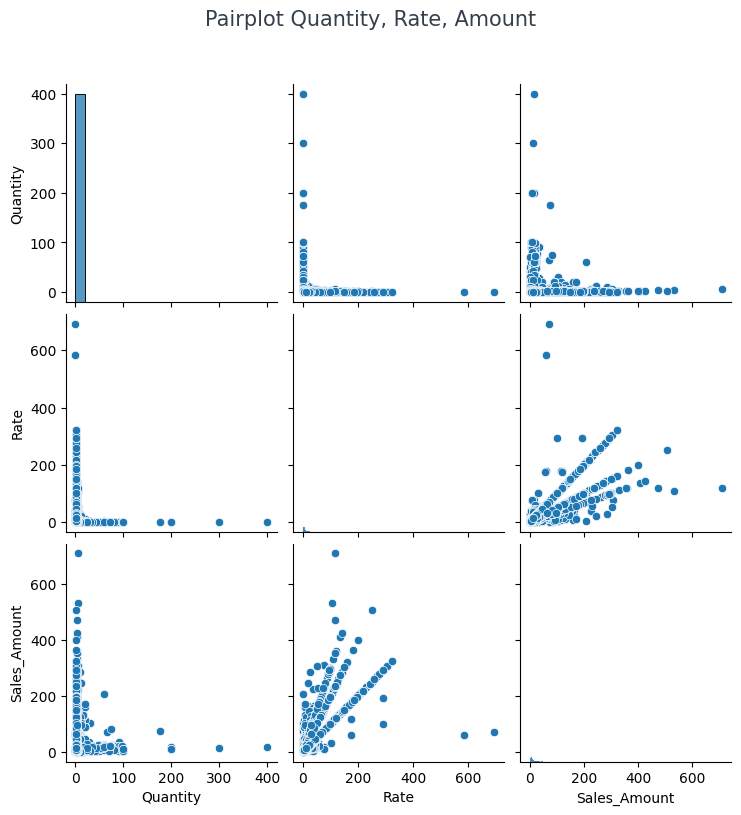

In [12]:
plt.rcParams['figure.figsize'] = 12,6
sns.pairplot(numeric_df)
plt.suptitle('Pairplot Quantity, Rate, Amount', fontsize = 15, y=1.08, color = '#333F4B')
plt.show();

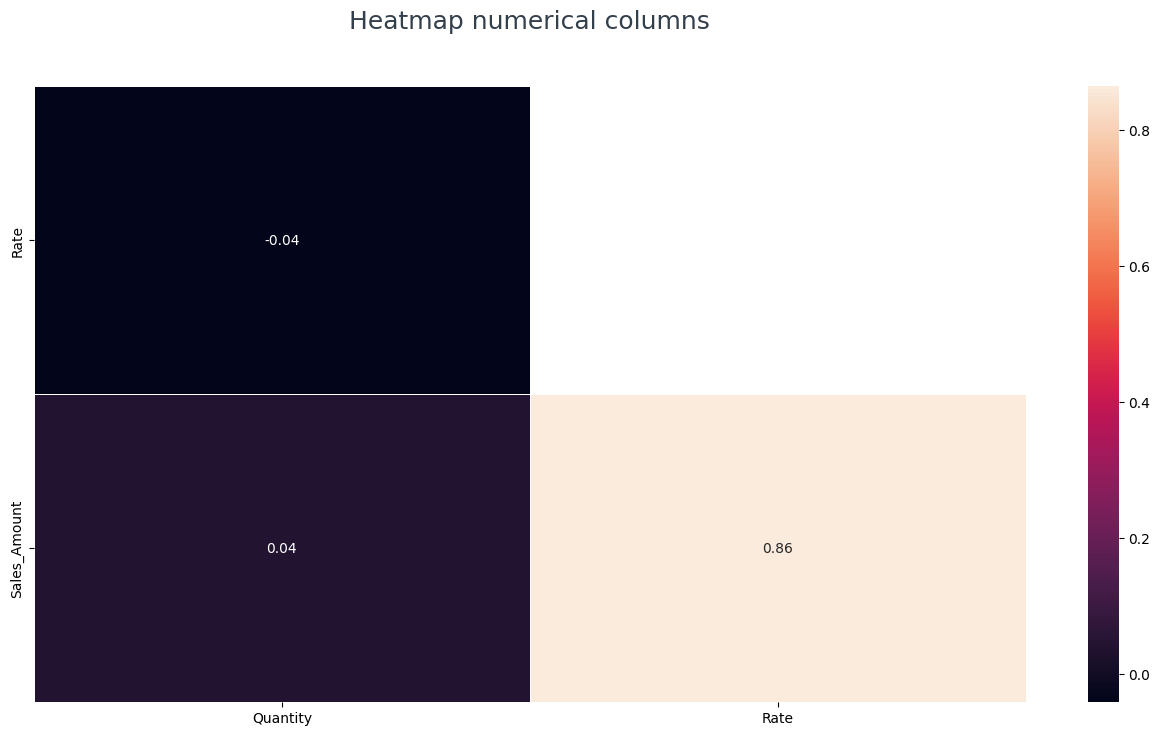

In [13]:
plt.rcParams['figure.figsize'] = 5,3

atm_corr = numeric_df.corr()
mask = np.ones_like(atm_corr, dtype=bool)

mask = np.triu(mask) 
mask = mask[1:,:-1]
atm_corr = atm_corr.iloc[1:,:-1]

plt.rcParams['figure.figsize'] = 16,8
sns.heatmap(atm_corr, mask = mask, annot = True, 
            fmt = '.2f', linecolor = 'white',linewidths=0.6)
plt.title('Heatmap numerical columns', fontsize = 18, y=1.08, color = '#333F4B')
plt.show()

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Có thể thấy thì với Quantity cao hay thấp thì đều xuất hiện các điểm có Rate/Amount cao và thấp $\rightarrow$ Điều này không có gì bất thường vì nó tùy thuộc vào cửa hàng và thông tin tên sản phẩm cũng đã bị giấu đi.</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Chính vì điều đó nên ta có thể thấy giữa Quantity tương quan yếu với Rate và Amount. </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Còn giữa Amount và Rate thì cơ bản 2 cột này là một nên nhóm sẽ ưu tiên dùng Rate tránh sự ảnh hưởng của Quantity.</span>

## 2.6 Thống kê dữ liệu category

In [14]:
category_df = retail_sale_df[['Date', 'Customer_ID',
                              'Transaction_ID', 'SKU_Category', 'SKU']]
category_df.agg([pd.Series.nunique])

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU
nunique,363,22625,64682,187,5242


<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Dữ liệu gồm 131.706 dòng nhưng chỉ có 64.682 giao dịch của 22.625 khách hàng $\rightarrow$ nếu giao dịch gồm nhiều sản phẩm thì sẽ tách ra thành nhiều dòng.</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Nhóm sẽ thống kê lại Amount dựa trên giao dịch, khách hàng, nhóm sản phẩm, sản phẩm để tìm ra một vài insight.</span>

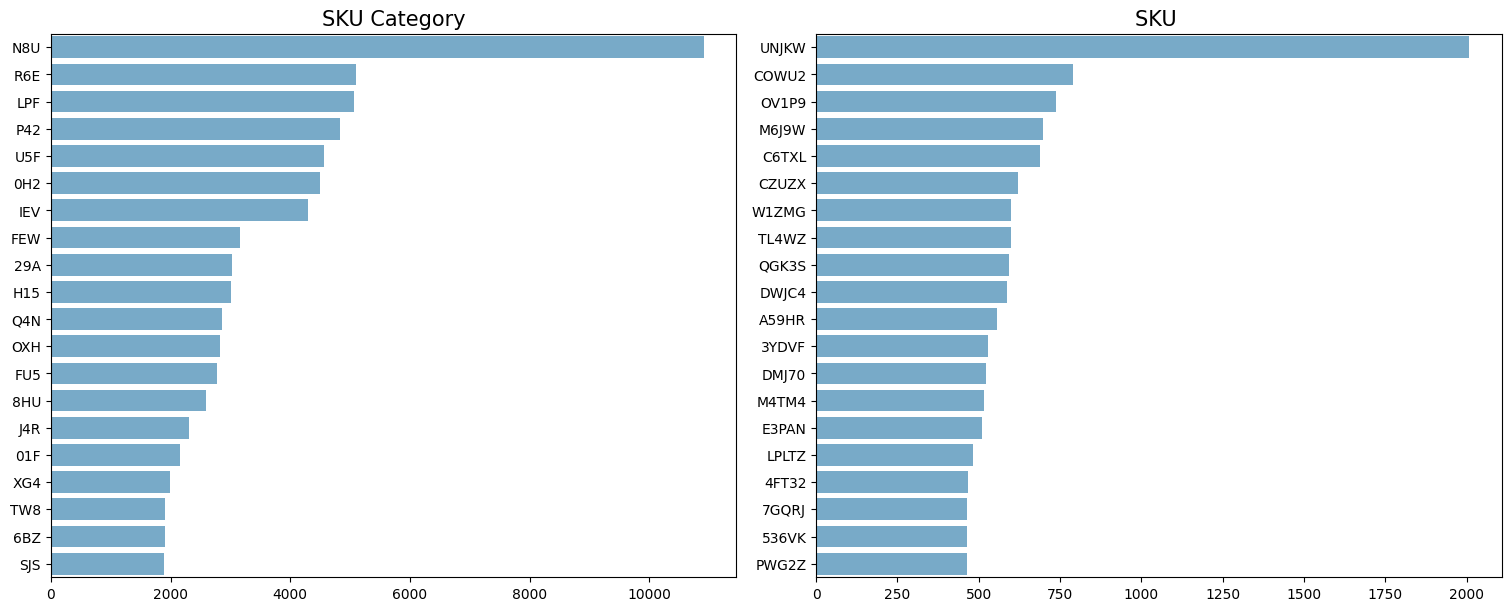

In [15]:
sku_cate_stats = category_df['SKU_Category'].value_counts(ascending=False).head(20)
sku_stats=category_df['SKU'].value_counts(ascending=False).head(20)

plt.rcParams['figure.figsize'] = 15,6
fig , axs = plt.subplots(1,2,constrained_layout = True)
sns.barplot(y = sku_cate_stats.index,
            x = sku_cate_stats.values,
            ax = axs[0], orient = 'h',
            palette = sns.color_palette('Blues',1), )
sns.barplot(y = sku_stats.index,
            x = sku_stats.values,
            ax = axs[1], orient = 'h',
            palette = sns.color_palette('Blues',1))

axs[0].set_title("SKU Category", fontsize = 15), axs[0].set(ylabel='')
axs[1].set_title("SKU ", fontsize = 15) , axs[1].set(ylabel='')

plt.show()

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> SKU Category thì `N8U` chiếm số lượng lớn xuất hiện trong các giao dịch. Còn SKU thì `UNJKW` chiếm số lượng lớn. </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Nhưng đây chỉ là thống kê số lần xuất hiện của sản phẩm, nhóm sản phẩm trong giao dịch chứ không phải số lượng thực tế bán ra.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các sản phẩm và nhóm sản phẩm còn lại trong top 10 thì không có sự chênh lệch đáng kể. </span>

# 3. EDA

## 3.1 Thống kê doanh thu theo giao dịch( Transaction_ID)

In [16]:
amount_by_transaction = retail_sale_df.groupby(['Transaction_ID'])[['Sales_Amount']].sum()\
                                      .sort_values('Sales_Amount', ascending=False)

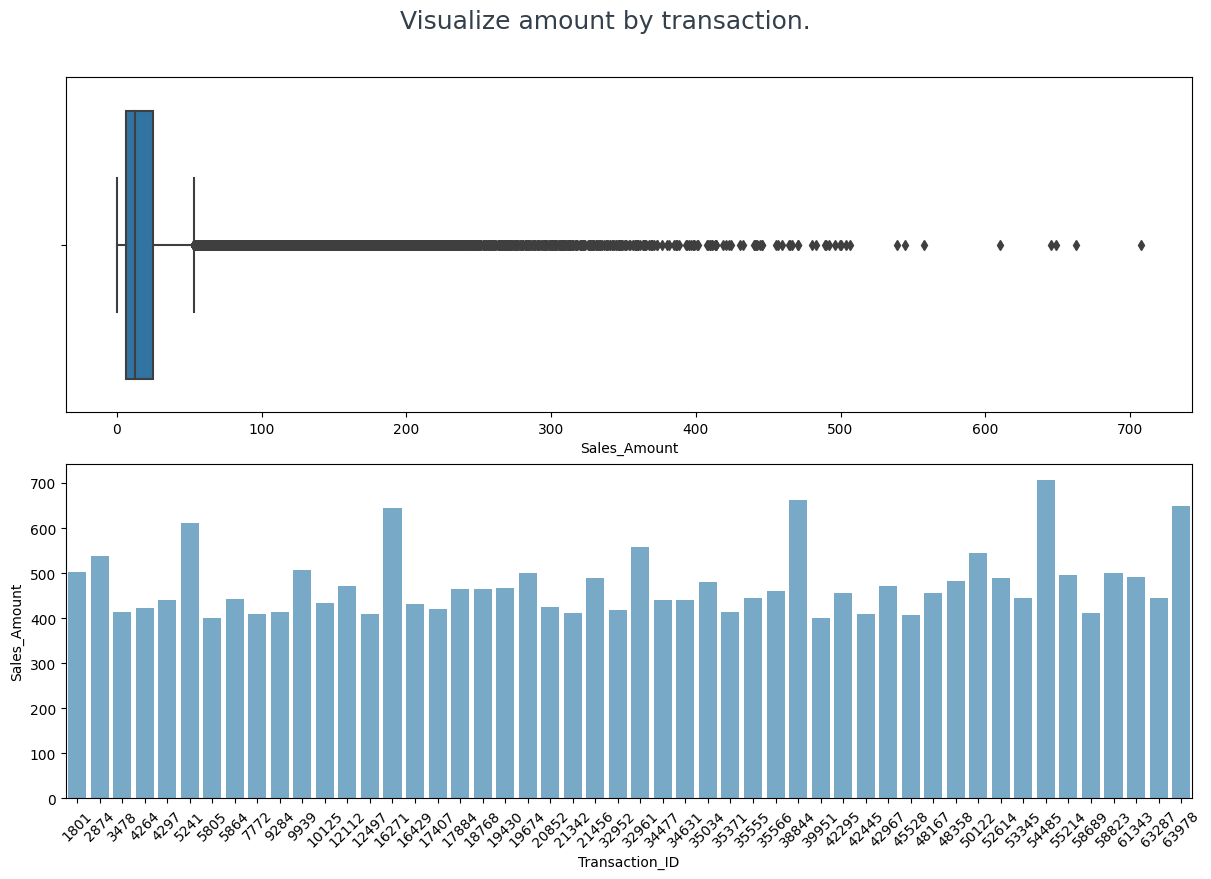

In [17]:
plt.rcParams['figure.figsize'] = 12,8
fig , axs = plt.subplots(2,1,constrained_layout = True)

sns.boxplot(x = amount_by_transaction['Sales_Amount'], ax = axs[0])
sns.barplot(x = amount_by_transaction.head(50).index, 
            y = amount_by_transaction.head(50)['Sales_Amount'], ax = axs[1], 
            palette = sns.color_palette('Blues',1))
axs[1].tick_params(axis='x', rotation=45)
plt.suptitle("Visualize amount by transaction.", fontsize = 18, y=1.08, color = '#333F4B')
plt.show()

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Phân bố của doanh thu theo giao dịch cũng không sai biệt quá nhiều với doanh thu theo sản phẩm.</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Dù đã nắm được doanh thu của từng giao dịch nhưng còn nhiều câu hỏi cần làm rõ như:</span>
    - <span style="font-size:17px;font-family: Times New Roman;"> Những giao dịch lớn trên thuộc về khách hàng nào ? Khách hàng đó thực hiện bao nhiêu giao dịch tại các điểm bán lẻ ?</span>
    - <span style="font-size:17px;font-family: Times New Roman;"> Số lượng sản phẩm và nhóm sản phẩm bán ra là bao nhiêu ? </span>

## 3.2 Thống kê các thông tin theo khách hàng cho từng giao dịch của họ 

In [18]:
customer_stats = pd.pivot_table(index=['Customer_ID', 'Transaction_ID'], values=['Sales_Amount', 'Quantity', 'SKU'],
                                data = retail_sale_df, aggfunc={'Sales_Amount': pd.Series.sum, 
                                                                'Quantity': pd.Series.sum, 
                                                                'SKU': 'count'})

In [19]:
retail_sale_df[retail_sale_df['Customer_ID'] == 33900]

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Rate


In [20]:
# display a customer
customer_stats[customer_stats.index.get_level_values(0) == 174]

Quantity  SKU  Sales_Amount
Customer_ID Transaction_ID                             
174         11359              6.000    4       229.530
            29334              8.000    4       356.670
            46460              1.000    1        50.800

### Thống kê số lượng giao dịch của những khách hàng thuộc top 50 giao dịch lớn nhất

In [21]:
top_transaction_df = customer_stats[customer_stats.index.get_level_values(1)\
                                .isin(amount_by_transaction.head(50).index)]

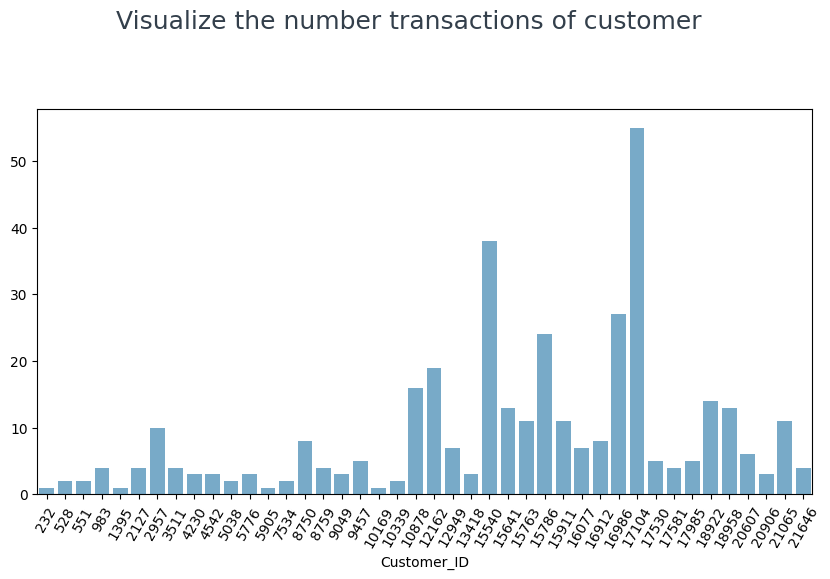

In [22]:
# id của top 1000 khách hàng thực hiện giao dịch lớn nhất
top_customer_id = top_transaction_df.index.get_level_values(0).values
top_customer_stats = customer_stats[customer_stats.index.get_level_values(0)\
                                .isin(top_customer_id)]
# số lần thực hiện giao dịch của những khách hàng trên
customer_id_stats = top_customer_stats.index.get_level_values(0).value_counts()

# visualize
plt.rcParams['figure.figsize'] = 10,5
ax = sns.barplot(x = customer_id_stats.index, 
            y = customer_id_stats.values, 
            palette = sns.color_palette('Blues',1))

ax.tick_params(axis='x', rotation=60)
plt.suptitle("Visualize the number transactions of customer ", fontsize = 18, y=1.08, color = '#333F4B')
plt.show()

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Có thể thấy những khách hàng này đa số đều thực hiện nhiều giao dịch, có những khách hàng với hơn 50 giao dịch. </span>

### Mối tương quan giữa số lượng giao dịch và tổng giá trị mua hàng của khách hàng.

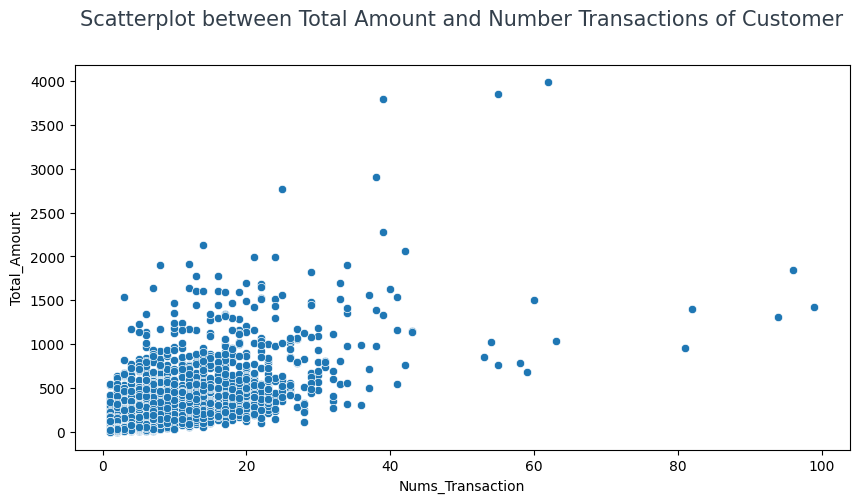

In [23]:
essential_df = pd.pivot_table(index=['Customer_ID'], values=['Transaction_ID', 'Sales_Amount'],
                                data = retail_sale_df, aggfunc={'Sales_Amount': pd.Series.sum, 
                                                                'Transaction_ID': pd.Series.nunique})
essential_df.rename(columns = {'Sales_Amount': 'Total_Amount', 
                               'Transaction_ID': 'Nums_Transaction'}, inplace=True)

plt.rcParams['figure.figsize'] = 10,5
sns.scatterplot(x = 'Nums_Transaction', y = 'Total_Amount', data = essential_df)

plt.title("Scatterplot between Total Amount and Number Transactions of Customer", fontsize = 15, y=1.08, color = '#333F4B')
plt.show()

### Thống kê top 20 sản phẩm theo số lượng thực tế bán ra.

In [24]:
top_sku_stats = retail_sale_df.groupby(['SKU'])['Quantity'].sum()\
                              .reset_index(name='Quantity')\
                              .sort_values(by='Quantity', ascending=False).head(20)

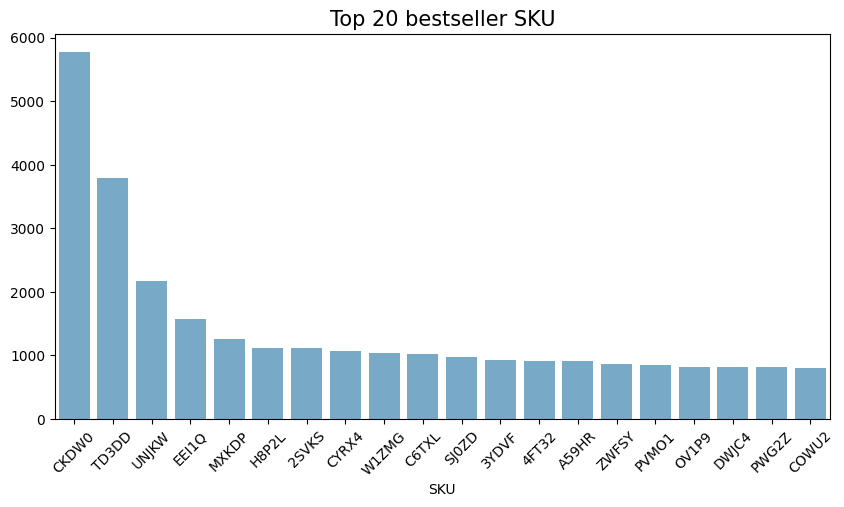

In [25]:
plt.rcParams['figure.figsize'] = 10,5
ax = sns.barplot(x = top_sku_stats['SKU'],
                 y = top_sku_stats['Quantity'],
                 palette = sns.color_palette('Blues',1))

ax.set_title("Top 20 bestseller SKU", fontsize = 15) , ax.set(ylabel='')
ax.tick_params(axis='x', rotation=45)
plt.show()

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét**:</span>
- <span style="font-size:17px;font-family: Times New Roman;">Có thể thấy sự khác biệt khi tính toán dựa trên số lượng bán ra của sản phẩm.</span>
- <span style="font-size:17px;font-family: Times New Roman;"> `UNJKW` có số lượng xuất hiện nhiều nhất nhưng chỉ xếp thứ 3 và số lượng bán ra chưa bằng 1/2 so với `CKDW0`. </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Các sản phẩm từ top 5 trở đi thì chênh lệch không đáng kể</span>

# 4. Xây dựng mô hình

<span style="font-size:18px;font-family: Times New Roman;"> **Input**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Dữ liệu sẽ gồm 22625 dòng và 5242 cột tương ứng cho 22625 khách hàng và 5242 mã SKU.</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Nếu khách hàng có mua sản phẩm đó thì giá trị là True, ngược lại sẽ là False. </span>


<span style="font-size:18px;font-family: Times New Roman;"> **Ouput**:</span>
- <span style="font-size:17px;font-family: Times New Roman;"> Các quy tắc kết hợp giữa các sản phẩm với nhau.</span>

In [26]:
# chuẩn bị data
final_data = retail_sale_df.groupby(['Customer_ID', 'SKU'])['Quantity']\
                           .sum().unstack().reset_index().fillna(0)\
                           .set_index('Customer_ID')

final_data = final_data.applymap(lambda x: True if x > 0 else False)

In [27]:
itemset_df = apriori(final_data, min_support=0.0005, use_colnames=True, low_memory=True)
itemset_df.tail(10)

,support,itemsets
3485,0.001,"(B87MU, C6TXL, LJ26I)"
3486,0.001,"(C6TXL, UNJKW, W1ZMG)"
3487,0.001,"(COWU2, UNJKW, DMJ70)"
3488,0.001,"(COWU2, UNJKW, EMJ1S)"
3489,0.001,"(M6J9W, COWU2, JJLXQ)"
3490,0.001,"(COWU2, UNJKW, JJLXQ)"
3491,0.001,"(COWU2, UNJKW, M4TM4)"
3492,0.001,"(M6J9W, COWU2, UNJKW)"
3493,0.001,"(COWU2, UNJKW, OV1P9)"
3494,0.001,"(M6J9W, UNJKW, OV1P9)"


### Phân biệt support, confidence, lift
- <span style="font-size:17px;font-family: Times New Roman;"> **Support**: cho biết mức độ phổ biến của một tập hợp vật phẩm trong tất cả giao dịch</span>
- <span style="font-size:17px;font-family: Times New Roman;"> **Confidence**: cho biết khả năng mặt hàng Y được mua khi mặt hàng X được mua, được biểu thị bằng {X -> Y}</span>
- <span style="font-size:17px;font-family: Times New Roman;"> **Lift**: cho biết khả năng mặt hàng Y được mua khi mặt hàng X được mua, đồng thời kiểm soát mức độ phổ biến của mặt hàng Y. </span>
    - <span style="font-size:17px;font-family: Times New Roman;"> Giá trị tăng lớn hơn 1 có nghĩa là mặt hàng Y có khả năng được mua nếu mặt hàng X được mua</span> 
    - <span style="font-size:17px;font-family: Times New Roman;"> Trong khi giá trị nhỏ hơn 1 có nghĩa là mặt hàng Y không có khả năng được mua nếu mặt hàng X được mua. </span>

- <span style="font-size:17px;font-family: Times New Roman;"> **Kết luận**: chọn những rule mà có confidence cao (confidence ~ 1) và lift càng lớn càng tốt (lift > 1). Vì ở đây nhóm lấy min_support khá nhỏ để có thể lấy được luật có ít nhất 2 item.</span>

In [33]:
rules = association_rules(itemset_df, metric="lift", min_threshold=1)
rules.sort_values(['support','confidence','lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1950,(COWU2),(UNJKW),0.030,0.073,0.007,0.220,3.024,0.004,1.189,0.690
1951,(UNJKW),(COWU2),0.073,0.030,0.007,0.091,3.024,0.004,1.067,0.722
2800,(M6J9W),(UNJKW),0.026,0.073,0.005,0.185,2.539,0.003,1.138,0.622
2801,(UNJKW),(M6J9W),0.073,0.026,0.005,0.066,2.539,0.003,1.043,0.654
2895,(OV1P9),(UNJKW),0.027,0.073,0.004,0.153,2.105,0.002,1.095,0.540
2894,(UNJKW),(OV1P9),0.073,0.027,0.004,0.057,2.105,0.002,1.032,0.566
2047,(CZUZX),(UNJKW),0.024,0.073,0.004,0.162,2.222,0.002,1.106,0.564
2046,(UNJKW),(CZUZX),0.073,0.024,0.004,0.054,2.222,0.002,1.031,0.593
1928,(M6J9W),(COWU2),0.026,0.030,0.004,0.140,4.665,0.003,1.128,0.806
1929,(COWU2),(M6J9W),0.030,0.026,0.004,0.120,4.665,0.003,1.108,0.810


<span style="font-size:18px;font-family: Times New Roman;"> **Một số luật kết hợp có thể đưa ra**:</span>
- <span style="font-size:17px;font-family: Times New Roman;">COWU2 $\rightarrow$ UNJKW</span>
- <span style="font-size:17px;font-family: Times New Roman;">M6J9W $\rightarrow$ UNJKW</span>
- <span style="font-size:17px;font-family: Times New Roman;">0T6EB $\rightarrow$ (0S4F6, 8YTMU)</span> \
...